![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

#### Resultados
* En promedio se rentan más bicicletas en temporada de verano, ya que tiene una media superior a las demás tmporadas con un valor de 234 bicicletas.
* Las horas del día en las que más bicicletas se rentan son 17,18 y 8, ya que en promedio se rentan 468,430 y 362 bicicletas respectivamente.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

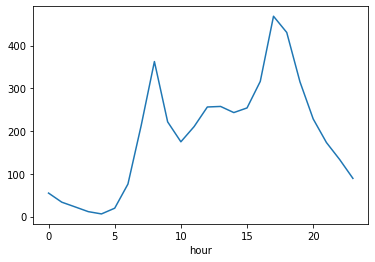

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

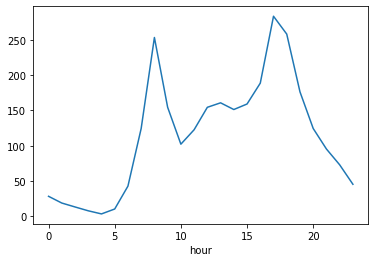

In [7]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

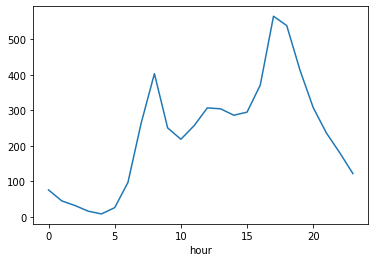

In [8]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot()

#### Resultados
* Tal y como se observa anteriormente, en la gráfica del promedio de bicicletas rentadas por hora sobresale que desde las 15 a las 17 horas se rentan más bicicletas que en el resto del día.
* al observar que el promedio de bicicletas rentadas por estación es mayor para el verano, también se observa esto en el alquiler de bicicletas en el inverno en dónde el promedio máximo para las 17 siendo la hora de mayor demanda es de 270, mientras que en el verano esta misma hora refleja alrededor de 525 .

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [9]:
#Dumificar la variable season
bikes_=bikes.copy()
bikes_d = pd.get_dummies(bikes['season'], prefix='season')
bikes_ = bikes.drop('season', axis=1)
bikes_dummies = pd.concat([bikes_, bikes_d], axis=1)
print(bikes_dummies.head())

                     holiday  workingday  weather  temp   atemp  humidity  \
datetime                                                                    
2011-01-01 00:00:00        0           0        1  9.84  14.395        81   
2011-01-01 01:00:00        0           0        1  9.02  13.635        80   
2011-01-01 02:00:00        0           0        1  9.02  13.635        80   
2011-01-01 03:00:00        0           0        1  9.84  14.395        75   
2011-01-01 04:00:00        0           0        1  9.84  14.395        75   

                     windspeed  casual  registered  total  hour  season_1  \
datetime                                                                    
2011-01-01 00:00:00        0.0       3          13     16     0         1   
2011-01-01 01:00:00        0.0       8          32     40     1         1   
2011-01-01 02:00:00        0.0       5          27     32     2         1   
2011-01-01 03:00:00        0.0       3          10     13     3         1  

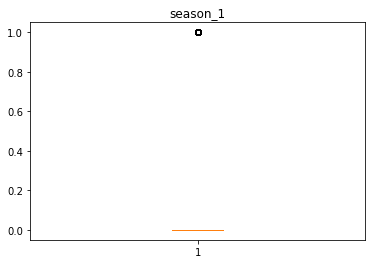

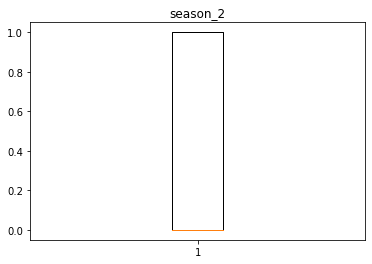

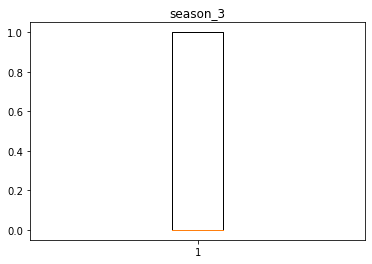

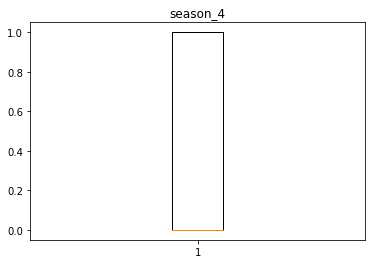

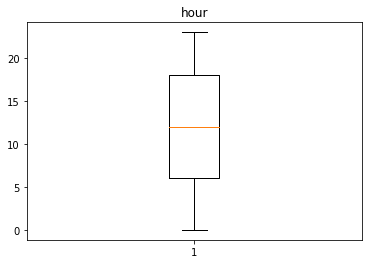

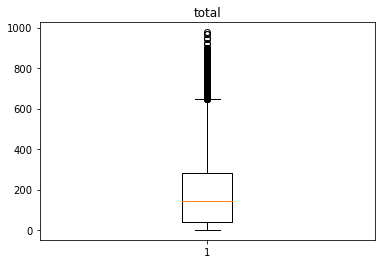

In [10]:
columns=['season_1','season_2','season_3','season_4','hour','total']
for col in bikes_dummies[columns]:
    plt.figure()
    plt.boxplot(bikes_dummies[col])
    plt.title(col)

# Mostrar los boxplots
plt.show()

In [11]:
# Celda 3
#definición test y train

XTotal=bikes_dummies[['season_1','season_2','season_3','season_4','hour']]
yTotal=bikes_dummies['total']
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)
def linear_regression(XTrain, XTest, yTrain, yTest):
    model = LinearRegression()
    model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    mse = mean_squared_error(yTest, yPred)
    r2 = r2_score(yTest, yPred)
    adj_r2 = 1 - (1-r2)*(len(yTest)-1)/(len(yTest)-XTest.shape[1]-1)
    print("Coeficientes: ", model.coef_)
    return [mse, adj_r2]
linear_regression(XTrain, XTest, yTrain, yTest)

Coeficientes:  [-76.79345561  24.11431232  42.2252086   10.45393469  10.62873885]


[25644.421108938277, 0.21408313805648105]

#### Resultados
* Luego de generar los dummies a partir de la variable season, y generar la regresión con el ajuste en el dataset, se obtiene un mse de 25.644 y un r2 ajustado de 0.214.
* Al generar los coeficientes, por ejemplo la variable season_3 indica que la cantidad de bicicletas alquiladas aumenta en promedio en 42.23 unidades cuando la temporada es la 3 (verano) y disminuye en que la cantidad de bicicletas alquiladas disminuye en promedio en 76.79 unidades cuando la temporada es la 1 (invierno).
* La variable a predecir "total" tiene demasiados outliers como se muestra anteriormente en el boxplot por ende, un modelo como la regresión lineal se ve afectado por esto, se recomienda usar un modelo que no se vea afectado por esto como un arbol de decisión.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [12]:

#División X y Y
print(bikes['total'].describe())
X = bikes[['season','hour']]
y = (bikes.total > 145).astype(int)
y

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: total, dtype: float64


datetime
2011-01-01 00:00:00    0
2011-01-01 01:00:00    0
2011-01-01 02:00:00    0
2011-01-01 03:00:00    0
2011-01-01 04:00:00    0
                      ..
2012-12-19 19:00:00    1
2012-12-19 20:00:00    1
2012-12-19 21:00:00    1
2012-12-19 22:00:00    0
2012-12-19 23:00:00    0
Name: total, Length: 10886, dtype: int32

In [13]:
# Celda 4

#Genera un arbol de decisión a partir de parámetros dados
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_




def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [14]:
#árbol con 6 nodos
tree=tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)
tree


{'y_pred': 0,
 'y_prob': 0.49917340191036,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 10886,
 'gain': 0.16178755449047394,
 'sl': {'y_pred': 0,
  'y_prob': 0.0942714126807564,
  'level': 1,
  'split': [1, 7.0],
  'n_samples': 3594,
  'gain': 0.06425451863089747,
  'sl': {'y_pred': 0,
   'y_prob': 0.026106335561922954,
   'level': 2,
   'split': [1, 6.0],
   'n_samples': 3139,
   'gain': 0.0027878761479700337,
   'sl': {'y_pred': 0,
    'y_prob': 0.010796723752792257,
    'level': 3,
    'split': -1,
    'n_samples': 2684,
    'gain': 0.0008089140964271449},
   'sr': {'y_pred': 0,
    'y_prob': 0.11816192560175055,
    'level': 3,
    'split': [0, 3.0],
    'n_samples': 455,
    'gain': 0.009214309359181827,
    'sl': {'y_pred': 0,
     'y_prob': 0.05240174672489083,
     'level': 4,
     'split': [0, 2.0],
     'n_samples': 227,
     'gain': 0.004655188204359839,
     'sl': {'y_pred': 0,
      'y_prob': 0.008695652173913044,
      'level': 5,
      'split': -1,
      'n_samples': 1

### Resultados
* Por último el arbol resultante tiene como hiperparámetros 6 nodos y 10 observaciones cómo mínimo por hoja.
* Se convierte la variable a predecir a categorica para cambiar el foco del problema a clasificación, utilizando la mediana marcando como alta demanda de alquiler desde un valor total mayor a 145 y un valor menor de esto como bajo.

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [15]:
# Celda 5

XTotal=bikes[['season','hour']]
yTotal=bikes['total']
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)
def decision_tree_regression(XTrain, XTest, yTrain, yTest, max_depth=None, min_samples_leaf=1):
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    mse = mean_squared_error(yTest, yPred)
    r2 = r2_score(yTest, yPred)
    adj_r2 = 1 - (1-r2)*(len(yTest)-1)/(len(yTest)-XTest.shape[1]-1)
    return [ mse, adj_r2]
decision_tree_regression=decision_tree_regression(XTrain, XTest, yTrain, yTest, max_depth=None, min_samples_leaf=1)
decision_tree_regression

[13395.201994797595, 0.5898243245275786]

In [16]:
from sklearn.model_selection import GridSearchCV

XTotal = bikes[['season', 'hour']]
yTotal = bikes['total']
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

model = DecisionTreeRegressor(min_samples_leaf=1)
params = {'max_depth': [2, 4, 6, 8, 10]}

grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(XTrain, yTrain)

best_model = grid_search.best_estimator_
yPred = best_model.predict(XTest)

mse = mean_squared_error(yTest, yPred)
r2 = r2_score(yTest, yPred)
adj_r2 = 1 - (1 - r2) * (len(yTest) - 1) / (len(yTest) - XTest.shape[1] - 1)

print(f"Best params: {grid_search.best_params_}")
print(f"MSE: {mse}")
print(f"Adj R2: {adj_r2}")


Best params: {'max_depth': 8}
MSE: 13387.970534365075
Adj R2: 0.5900457597227113


* Como se observa anteriormente se obtuvo inicialmente un mse de 13.395 y un r2 ajustado de 0.5898, luego de realizar gridsearch para iterar y buscar el hiperparámetro max depth que mejor mse y r2 ajustado arroje, para esto con 8 capas o nodos de profundidad se tiene un mse de 13.387 y un r2 ajustado de 0.590

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [17]:
# Lectura de la información de archivo .csv
df = pd.read_csv('mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [18]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [19]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [20]:
# Celda 6
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score



#decision tree
tree = DecisionTreeClassifier(max_depth=5, random_state=0)
tree.fit(X_train, y_train)

# Predecir los valores de la variable objetivo en los datos de prueba
y_pred = tree.predict(X_test)

# Calcular la precisión, f1 score y mostrar los resultados
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")




Accuracy: 0.64, F1 Score: 0.64


In [21]:
accuracy_list = []
f1_list = []
depth_list = []

#calibración utilizando max_depth
for i in range(1, 101):
    # Crear y ajustar el modelo de árbol de decisión con la profundidad actual
    tree = DecisionTreeClassifier(max_depth=i, random_state=0)
    tree.fit(X_train, y_train)

    # Predecir los valores de la variable objetivo en los datos de prueba
    y_pred = tree.predict(X_test)

    # Calcular la precisión y el f1 score y agregarlos a las listas correspondientes
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy_list.append(accuracy)
    f1_list.append(f1)
    depth_list.append(i)

# Encontrar la profundidad con el máximo f1 score y la máxima precisión
max_accuracy_depth = depth_list[accuracy_list.index(max(accuracy_list))]
max_f1_depth = depth_list[f1_list.index(max(f1_list))]

# Mostrar los resultados
print(f"La profundidad que maximiza la precisión es: {max_accuracy_depth}")
print(f"La precisión máxima obtenida es: {max(accuracy_list):.2f}")
print(f"La profundidad que maximiza el f1 score es: {max_f1_depth}")
print(f"El f1 score máximo obtenido es: {max(f1_list):.2f}")


La profundidad que maximiza la precisión es: 4
La precisión máxima obtenida es: 0.65
La profundidad que maximiza el f1 score es: 4
El f1 score máximo obtenido es: 0.65


In [22]:
#logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ajustar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 score:", f1)


Accuracy: 0.6275
F1 score: 0.6102877070619006


* Al generar el primer arbol se obtubo un accuracy de 0.64 y un f1 score 0.64, luego de iterar para encontrar la profundidad de las capas máxima que genera el mejor accuracy y f1 score es de 1, 0.66 y 0.66 respectivamente.
* La regresión logistica obtuvo un valor de accuracy de 0.62 y un f1 score de 0.610.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [23]:
# Celda 7
# 
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())



,count,percentage
1,3000,0.5
0,3000,0.5


* Como se observa anteriormente la variable clase si es popular o no tiene la misma cantidad de registros para los dos grupos.

In [24]:
#partición de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
##max depth=15

#decision tree
tree = DecisionTreeClassifier(max_depth=15, random_state=0)
tree.fit(X_train, y_train)

# Predecir los valores de la variable objetivo en los datos de prueba
y_pred = tree.predict(X_test)

# Calcular la precisión, f1 score y mostrar los resultados
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")


Accuracy: 0.57, F1 Score: 0.57


In [26]:
#100 arboles con max depth=15

n_estimators = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=300)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=15, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

    
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()
# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
from sklearn import metrics
print('f1 score: '+str(metrics.f1_score(y_pred, y_test)))
print('accuracy:'+str(metrics.accuracy_score(y_pred, y_test)))

f1 score: 0.6599999999999999
accuracy:0.6565656565656566


* Luego de generar un arbol con el hiperparámetro elegido max_depth=15, se obtiene un valor de 0.57 tanto para el accuracy como el f1 score, mientras que al realizar el ensamblaje de 100 arboles distintos generados por el método de votación mayoritaria se obtiene un valor de f1 score de 0.6599 y un accuracy de 0.6565, mejorando bastante la predicción.

In [27]:
#min_samples_leaf=3

#decision tree
tree = DecisionTreeClassifier(max_depth=None, random_state=0,min_samples_leaf=3)
tree.fit(X_train, y_train)

# Predecir los valores de la variable objetivo en los datos de prueba
y_pred = tree.predict(X_test)

# Calcular la precisión, f1 score y mostrar los resultados
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")

Accuracy: 0.56, F1 Score: 0.56


In [28]:
#min_samples_leaf=3

n_estimators = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=300)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i],min_samples_leaf=3)
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

    
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()
# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
from sklearn import metrics
print('f1 score: '+str(metrics.f1_score(y_pred, y_test)))
print('accuracy:'+str(metrics.accuracy_score(y_pred, y_test)))

f1 score: 0.647239263803681
accuracy:0.6515151515151515


* Luego de generar un arbol con el hiperparámetro elegido min_samples_leaf=3, se obtiene un valor de 0.56 tanto para el accuracy como el f1 score, mientras que al realizar el ensamblaje de 100 arboles distintos generados por el método de votación mayoritaria se obtiene un valor de f1 score de 0.6472 y un accuracy de 0.6515, mejorando bastante la predicción.

In [29]:
#logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ajustar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 score:", f1)

Accuracy: 0.6275
F1 score: 0.6102877070619006


In [30]:
#regression logistic
n_estimators = 100
n_bootstrap = 300

log_regs = {}
for i in range(n_estimators):
    bootstrap_indices = np.random.choice(X_train.index, size=n_bootstrap, replace=True)
    X_train_bootstrap = X_train.loc[bootstrap_indices]
    y_train_bootstrap = y_train.loc[bootstrap_indices]

    log_regs[i] = LogisticRegression(random_state=seeds[i])
    log_regs[i].fit(X_train_bootstrap, y_train_bootstrap)

y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = log_regs[i].predict(X_test)

y_pred_ = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
from sklearn import metrics
print(metrics.f1_score(y_pred_, y_test))
print(metrics.accuracy_score(y_pred_, y_test))

0.6172839506172839
0.6383333333333333


* Luego de generar un arbol con el hiperparámetro elegido min_samples_leaf=3, se obtiene un valor de 0.62 para el accuracy y 0.61 para el f1 score, mientras que al realizar el ensamblaje de 100 regresiones distintas generados por el método de votación mayoritaria se obtiene un valor de f1 score de 0.6172 y un accuracy de 0.63, mejorando bastante la predicción.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

(0.6583333333333332, 0.6583333333333333)

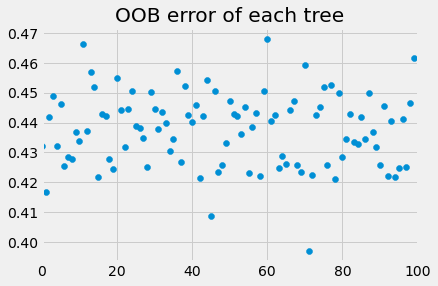

In [31]:
# Celda 8
#100 arboles con max depth=15

n_estimators = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=300)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=15, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

    
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
    errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)
    # Visualización de OOB para cada árbol
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error of each tree')

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
weighted_sum_1.head(20)
# Desempeño al hacer votación ponderada
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)


* Al generar el ensamblaje de 100 arboles distintos generados por el método de votación ponderada se obtiene un valor de f1 score de 0.6583 y un accuracy de 0.6583

(0.636672325976231, 0.6433333333333333)

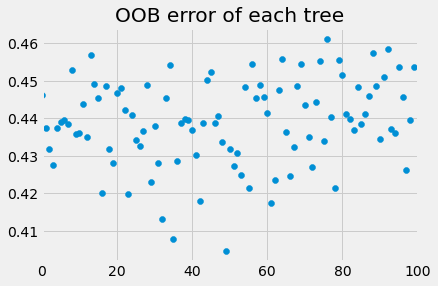

In [32]:
#100 arboles con min_samples_leaf=3

n_estimators = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=300)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i],min_samples_leaf=3)
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

    
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
    errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)
    # Visualización de OOB para cada árbol
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error of each tree')


# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
weighted_sum_1.head(20)
# Desempeño al hacer votación ponderada
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

* Al generar el ensamblaje de 100 arboles distintos generados por el método de votación ponderada se obtiene un valor de f1 score de 0.636 y un accuracy de 0.6433

In [ ]:
#Regression Logistic

n_estimators = 100
n_bootstrap = 300

log_regs = {}
for i in range(n_estimators):
    bootstrap_indices = np.random.choice(X_train.index, size=n_bootstrap, replace=True)
    X_train_bootstrap = X_train.loc[bootstrap_indices]
    y_train_bootstrap = y_train.loc[bootstrap_indices]

    log_regs[i] = LogisticRegression(random_state=seeds[i])
    log_regs[i].fit(X_train_bootstrap, y_train_bootstrap)

y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = log_regs[i].predict(X_test)

samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
    errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)
    # Visualización de OOB para cada árbol
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error of each tree')


# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
weighted_sum_1.head(20)
# Desempeño al hacer votación ponderada
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

* Al generar el ensamblaje de 100 regresiones distintas generados por el método de votación ponderada se obtiene un valor de f1 score de 0.6153 y un accuracy de 0.6375

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9


Por último, comparando los dos métodos dan resultados muy similares, encontrando un poco mejor el poder predictivo utilizando el método de votación mayoritaria, ya que incluye los modelos que obtivieron la mayor cantidad de valores predichos de la clase positiva o negativa y genera una predicción a partir de las predicciones de los mismos, este modelo es especialmente favorable para modelos en los que la variable respuesta tenga dos clases, mientras que la votación ponderada utilizando oob selecciona los modelos que mejor predicción realizaron, comparandoles con los registros que no estuvieron en la etapa de muestro por bootstrap, por ende para esta situación particular el modelo de ensamblaje por votación mayoritaria obtiene una mejor predicción.